### Imports

Required packages including those needed for `image_arrays.py` and `hdf_utils.py`.
- h5py
- numpy
- scipy
- matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

# local imports
from image_arrays import *
from hdf_utils import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Load triggered stimulus data

In [3]:
with h5.File("triggered_stimuli.h5") as f:
    d = unpack_hdf(f)

### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`).

- `delta` sets the number of timesteps/frames that are scrolled per tick
- `roi_size` sets dynamic ROI size in pixels. This can either be scalar (e.g. `1`), or a tuple (e.g. `(1, 2)`) if you want a non-square ROI 

<IPython.core.display.Javascript object>


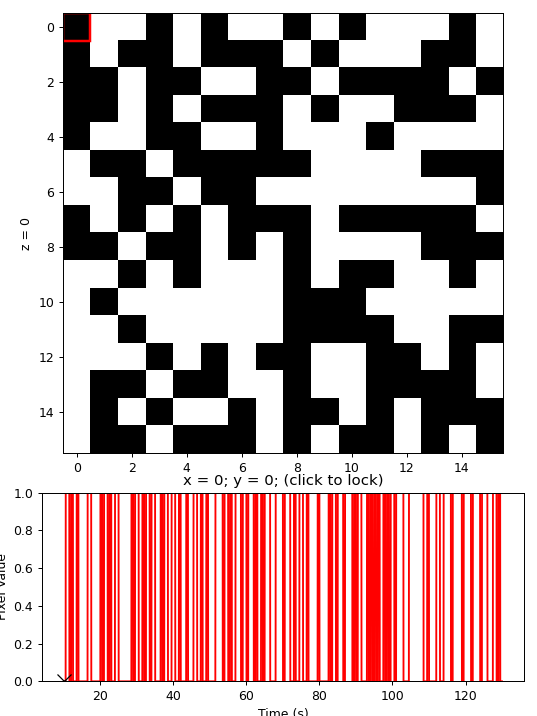

In [4]:
raw_noise_plot = StackExplorer(
    d["raw_noise"],
    zaxis=d["noise_xaxis"],
    delta=10,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
raw_noise_plot.ax[1].set_xlabel("Time (s)")
raw_noise_plot.ax[1].set_ylabel("Pixel Value")

raw_noise_plot.fig.show()

### Dynamic ROI plot of recordings
Trial to display in the stack axis can be selected with the slider, with the last position being the average. The currently selected trial will be highlighted in **red**. Use mouse scroll to cycle through frames of the movies. Beams of the outlined ROI are displayed below with the current trial highlighted in red. The average beam is displayed with a thicker linewidth and greater opacity.

- `delta` sets the number of timesteps/frames that are scrolled per tick
- `roi_size` sets dynamic ROI size in pixels. This can either be scalar (e.g. `1`), or a tuple (e.g. `(1, 2)`) if you want a non-square ROI 

**NOTE:** If the recordings are large, this will use up a lot of RAM.

<IPython.core.display.Javascript object>


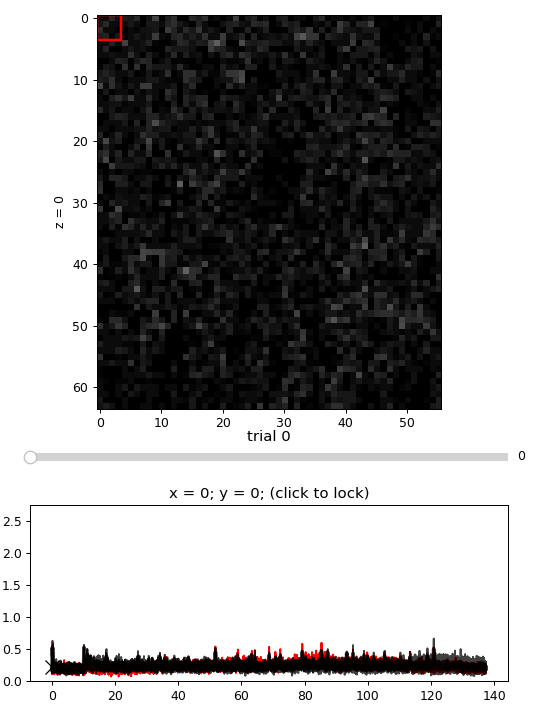

Recording shape: (8000, 64, 56)


In [5]:
stacks_plot = StackExplorer(
    d["recs"],
    zaxis=d["recs_xaxis"],
    delta=5,
    roi_sz=4,
    vmin=0,
    figsize=(6, 8)
)
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", d["recs"][0].shape)
stacks_plot.fig.show()

### Event triggered average of stimulus

This is the average stimulus that preceded events (with some time proceeding included) in each ROI. ROIs can be browsed via slider, and their physical position relative to the stimulus is shown by the **blue x**.

A 2Hz sine wave (one cycle) convolved version of the triggered stimulus has also been included in the data pack. To view that version instead, set `convolved_mode = True`.

<IPython.core.display.Javascript object>


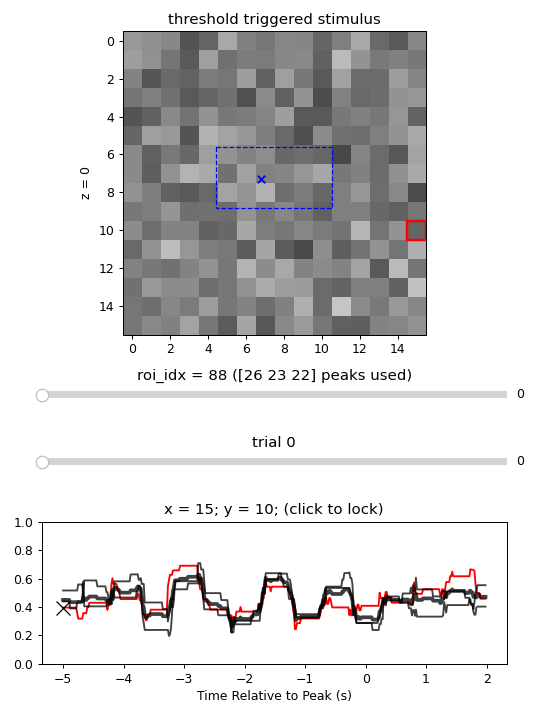

In [6]:
convolved_mode = False

if convolved_mode:
    lead = d["lead_conv"]
    vmin = -0.15
    vmax = 0.15
else:
    lead = d["lead"]
    vmin = 0.
    vmax = 1.

def roi_fmt_fun(i):
    return "roi_idx = %i (%s peaks used)" % (d["pos_to_roi"][i], str(d["n_peaks_used"][i]))

lead_stack_plot = StackExplorer(
    lead,
    zaxis=d["lead_xaxis"],
    delta=2,
    roi_sz=1,
    vmin=vmin,
    vmax=vmax,
    n_fmt_fun=roi_fmt_fun,
    figsize=(6, 8)
)
lead_stack_plot.stack_ax.set_title("threshold triggered stimulus")
lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

def scan_field_rect():
    return Rectangle(
        (d["x_corner_scaled"] - .5, d["y_corner_scaled"] - .5),  # grid offset
        d["rec_width"] / d["stim_width"] * d["raw_noise"].shape[2], 
        d["rec_height"] / d["stim_height"] * d["raw_noise"].shape[1], 
        fill=False,
        color="blue",
        linewidth=1,
        linestyle="--"
    )

def update_roi_mark(mark):
    def f(i):
#         idx = pos_to_roi[int(i)]
        x, y = d["roi_locs"][int(i)]
        x = x * d["col_x"] + d["x_corner_phys"] + (d["grid_w"] / 2 * d["col_x"])
        y = y * d["row_y"] + d["y_corner_phys"] + (d["grid_h"] / 2 * d["row_y"])
        x = x / d["stim_width"] * d["raw_noise"].shape[2] - 0.5
        y = y / d["stim_height"] * d["raw_noise"].shape[1] - 0.5
        mark.set_offsets([[x, y]])
    return f

lead_stack_plot.ax[0].add_patch(scan_field_rect())
lead_roi_mark = lead_stack_plot.ax[0].scatter([0], [0], marker="x", c="blue")
update_roi_mark(lead_roi_mark)(0)    
lead_stack_plot.n_slider.on_changed(update_roi_mark(lead_roi_mark))

lead_stack_plot.fig.show()

### Cross-ROI event triggered events

Each ROI is used to trigger averages of all the ROIs (including themselves) on a trial-by-trial basis. This can be interpreted as a simplistic view of the correlation between ROIs over space. Triggered events comparable in size to that in the reference ROI are highly likely to have events occuring in unison.

<IPython.core.display.Javascript object>


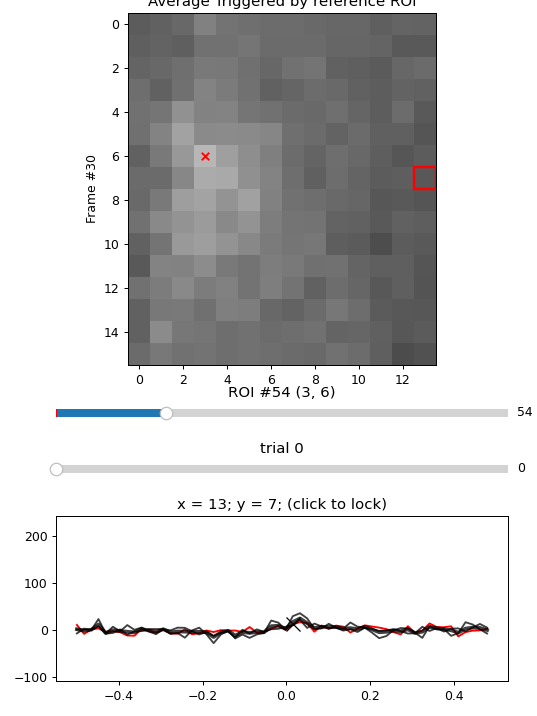

Text(0.5, 1.0, 'Average Triggered by reference ROI')

In [7]:
triggered_event_plot = StackExplorer(
    d["triggered_events"] - d["triggered_events"].mean(axis=2, keepdims=True),
    zaxis=d["event_xaxis"],
    delta=1,
    roi_sz=1,
    auto_roi_scale=False,
    z_fmt_fun=(lambda i: "Frame #%i" % i),
    n_fmt_fun=lambda i: "ROI #%i (%i, %i)" % (i, i // d["grid_rows"], i % d["grid_rows"]),
    figsize=(6, 8)
)
triggered_event_plot.ax[2].set_xlabel("Time (s)")
triggered_event_plot.ax[2].set_ylabel("Response")
triggered_roi_mark = triggered_event_plot.ax[0].scatter([0], [0], marker="x", c="red")
triggered_event_plot.n_slider.on_changed(
    lambda v: triggered_roi_mark.set_offsets([[v // d["grid_rows"], v % d["grid_rows"]]]))

triggered_event_plot.ax[0].set_title("Average Triggered by reference ROI")